# Deep Learning Assignment 2: Legal Clause Similarity Analysis

This notebook implements two baseline models from scratch for **legal clause similarity** tasks:
1. **BiLSTM (Bidirectional LSTM)** - Sequential model for legal text representation
2. **Siamese CNN** - Convolutional Neural Network with Siamese architecture

## Task Overview
In the context of legal clause similarity, the goal is to quantify the semantic relationship between two legal clauses. This involves:

### Key Dimensions of Similarity:
- **Semantic Equivalence**: Whether two clauses express the same legal principle, even if phrased differently
- **Contextual Relatedness**: Whether two clauses address related legal concepts or topics

### Dataset Structure:
- CSV files denote distinct clause categories (e.g., acceleration, access-to-information)
- Each clause has text and corresponding clause type label
- Enables study of semantic similarity within and across categories

## Hardware Configuration
- **GPU**: 2x NVIDIA Tesla T4 GPUs (Kaggle)
- **Framework**: PyTorch with CUDA support

## 1. Environment Setup and GPU Configuration

In [1]:
# Import necessary libraries
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    
print(f"\nUsing device: {device}")

PyTorch Version: 2.6.0+cu124
CUDA Available: True
Number of GPUs: 2
GPU 0: Tesla T4
GPU 1: Tesla T4

Using device: cuda:0


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("bahushruth/legalclausedataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/legalclausedataset


## 2. Data Loading and Preprocessing Module

This module handles:
- Loading legal clause data from CSV
- Text tokenization and vocabulary building
- Creating positive and negative pairs for similarity learning
- Word embeddings (random initialization, trained from scratch)
- Dataset creation and batching



### Vocabulary Building and Tokenization

In [3]:
# Build vocabulary from text corpus
def build_vocabulary(texts, max_vocab_size=10000):
    word2idx = {"<PAD>": 0, "<UNK>": 1, "<SOS>": 2, "<EOS>": 3}
    idx2word = {0: "<PAD>", 1: "<UNK>", 2: "<SOS>", 3: "<EOS>"}
    word_freq = {}
    
    # Count word frequencies
    for text in texts:
        for word in str(text).lower().split():
            word_freq[word] = word_freq.get(word, 0) + 1
    
    # Sort by frequency and take top max_vocab_size
    sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
    sorted_words = sorted_words[:max_vocab_size - 4]
    
    # Add to vocabulary
    for idx, (word, freq) in enumerate(sorted_words, start=4):
        word2idx[word] = idx
        idx2word[idx] = word
    
    return word2idx, idx2word
    

# Convert text to sequence of indices
def encode_text(text, word2idx, max_length=None):
    words = str(text).lower().split()
    indices = [word2idx.get(word, word2idx["<UNK>"]) for word in words]
    
    # Pad or truncate
    if max_length:
        if len(indices) < max_length:
            indices += [word2idx["<PAD>"]] * (max_length - len(indices))
        else:
            indices = indices[:max_length]
    
    return indices


# Convert indices back to text
def decode_text(indices, idx2word):
    words = [idx2word.get(idx, "<UNK>") for idx in indices if idx != 0]  # Skip PAD
    return " ".join(words)


### Dataset Loading and Preprocessing

In [4]:
# Load all legal clause CSV files from dataset folder
def load_all_legal_clauses(dataset_folder, max_files=None):
    import glob
    
    csv_files = glob.glob(os.path.join(dataset_folder, '*.csv'))
    
    if max_files:
        csv_files = csv_files[:max_files]
    
    print(f"Found {len(csv_files)} CSV files in {dataset_folder}")
    print(f"Loading clause categories...")
    
    all_dfs = []
    category_stats = {}
    
    for csv_file in csv_files:
        try:
            df = pd.read_csv(csv_file)
            if 'clause_text' in df.columns and 'clause_type' in df.columns:
                category_name = os.path.basename(csv_file).replace('.csv', '')
                num_clauses = len(df)
                all_dfs.append(df)
                category_stats[category_name] = num_clauses
                print(f"  ✓ {category_name}: {num_clauses} clauses")
            else:
                print(f"  ⚠ Skipping {os.path.basename(csv_file)} - missing required columns")
        except Exception as e:
            print(f"  ✗ Error loading {os.path.basename(csv_file)}: {e}")
    
    # Combine all dataframes
    combined_df = pd.concat(all_dfs, ignore_index=True)
    
    print(f"\n{'='*70}")
    print(f"DATASET SUMMARY")
    print(f"{'='*70}")
    print(f"Total clause categories: {len(category_stats)}")
    print(f"Total clauses: {len(combined_df)}")
    print(f"Unique clause types: {combined_df['clause_type'].nunique()}")
    print(f"{'='*70}")
    
    return combined_df, category_stats


def load_legal_clause_data(csv_path):
    """Load legal clause data from single CSV file"""
    df = pd.read_csv(csv_path)
    print(f"Loaded {len(df)} clauses from {csv_path}")
    print(f"Columns: {df.columns.tolist()}")
    print(f"\nFirst few rows:")
    print(df.head())
    return df


# Create positive and negative pairs from legal clauses
# Positive pairs: Same clause type (semantic equivalence)
# Negative pairs: Different clause types (contextual relatedness)
def create_clause_pairs(df, n_positive_pairs=None, n_negative_pairs=None, seed=42):
    np.random.seed(seed)
    
    clauses = df['clause_text'].values
    labels_col = df['clause_type'].values
    
    text1_list = []
    text2_list = []
    labels = []
    
    # Group clauses by type
    clause_groups = {}
    for clause, label in zip(clauses, labels_col):
        if label not in clause_groups:
            clause_groups[label] = []
        clause_groups[label].append(clause)
    
    # Remove categories with only 1 clause
    clause_groups = {k: v for k, v in clause_groups.items() if len(v) >= 2}
    
    print(f"\n{'='*70}")
    print(f"CLAUSE CATEGORIES")
    print(f"{'='*70}")
    print(f"Number of categories: {len(clause_groups)}")
    
    # Display category distribution
    category_counts = {k: len(v) for k, v in clause_groups.items()}
    sorted_categories = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)
    print(f"\nTop 10 categories by clause count:")
    for cat, count in sorted_categories[:10]:
        print(f"  • {cat}: {count} clauses")
    if len(sorted_categories) > 10:
        print(f"  ... and {len(sorted_categories) - 10} more categories")
    
    print(f"\n{'='*70}")
    print(f"CREATING POSITIVE PAIRS (Same Clause Type)")
    print(f"{'='*70}")
    
    positive_count = 0
    category_list = list(clause_groups.keys())
    
    # Sample pairs from each category proportionally
    for category in category_list:
        clause_list = clause_groups[category]
        
        # Generate all possible pairs for this category
        pairs_available = len(clause_list) * (len(clause_list) - 1) // 2
        
        # Sample a subset if n_positive_pairs is specified
        if n_positive_pairs:
            pairs_to_sample = min(pairs_available, max(1, n_positive_pairs // len(category_list)))
        else:
            pairs_to_sample = pairs_available
        
        sampled = 0
        for i in range(len(clause_list)):
            for j in range(i + 1, len(clause_list)):
                if sampled >= pairs_to_sample:
                    break
                text1_list.append(clause_list[i])
                text2_list.append(clause_list[j])
                labels.append(1)  # Similar
                positive_count += 1
                sampled += 1
                
                if n_positive_pairs and positive_count >= n_positive_pairs:
                    break
            if n_positive_pairs and positive_count >= n_positive_pairs:
                break
        if n_positive_pairs and positive_count >= n_positive_pairs:
            break
    
    print(f"Created {positive_count} positive pairs")
    
    print(f"CREATING NEGATIVE PAIRS (Different Clause Types)")
    
    negative_count = 0
    target_negative = n_negative_pairs if n_negative_pairs else positive_count
    
    # Create a mapping of clause to its type for efficient lookup
    clause_to_type = {clause: label for clause, label in zip(clauses, labels_col)}
    
    # Sample pairs from different categories
    attempts = 0
    max_attempts = target_negative * 10
    
    while negative_count < target_negative and attempts < max_attempts:
        idx1, idx2 = np.random.choice(len(clauses), 2, replace=False)
        clause1, clause2 = clauses[idx1], clauses[idx2]
        
        # Ensure they are from different clause types
        if clause_to_type.get(clause1) != clause_to_type.get(clause2):
            text1_list.append(clause1)
            text2_list.append(clause2)
            labels.append(0)  # Dissimilar
            negative_count += 1
        
        attempts += 1
    
    print(f"Created {negative_count} negative pairs")
    
    print(f"DATASET PAIR SUMMARY")
    print(f"Total pairs: {len(labels)}")
    print(f"Positive (similar - same type): {sum(labels)} ({sum(labels)/len(labels)*100:.1f}%)")
    print(f"Negative (dissimilar - diff type): {len(labels) - sum(labels)} ({(len(labels)-sum(labels))/len(labels)*100:.1f}%)")
    
    return text1_list, text2_list, labels


# Create PyTorch-ready dataset from text pairs
def create_dataset(text1_list, text2_list, labels, word2idx, max_length):
    data = []
    for text1, text2, label in zip(text1_list, text2_list, labels):
        encoded1 = encode_text(text1, word2idx, max_length)
        encoded2 = encode_text(text2, word2idx, max_length)
        
        data.append({
            'text1': torch.LongTensor(encoded1),
            'text2': torch.LongTensor(encoded2),
            'label': torch.FloatTensor([label])
        })
    
    return data


# Custom collate function for DataLoader
def collate_fn(batch):
    text1 = torch.stack([item['text1'] for item in batch])
    text2 = torch.stack([item['text2'] for item in batch])
    labels = torch.stack([item['label'] for item in batch])
    
    return {
        'text1': text1,
        'text2': text2,
        'label': labels
    }

### Load and prepare data

In [5]:
# Load all CSV files from Dataset folder
dataset_folder = '/kaggle/input/legalclausedataset'  # Folder containing all clause CSVs
df, category_stats = load_all_legal_clauses(dataset_folder, max_files=None)

# Display dataset information
print(f"DATASET INFORMATION")
print(f"\nDataFrame shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nSample clauses:")
print(df.head(3))

# Create pairs (limit to prevent memory issues, adjust as needed)
text1_list, text2_list, labels = create_clause_pairs(
    df, 
    n_positive_pairs=2000,  # Increased for multi-category dataset
    n_negative_pairs=2000,   # Increased for multi-category dataset
    seed=42
)

# Split data
text1_train, text1_temp, text2_train, text2_temp, y_train, y_temp = train_test_split(
    text1_list, text2_list, labels, test_size=0.3, random_state=42, stratify=labels
)
text1_val, text1_test, text2_val, text2_test, y_val, y_test = train_test_split(
    text1_temp, text2_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("BUILDING VOCABULARY")


# Build vocabulary from training data
all_texts = text1_train + text2_train
word2idx, idx2word = build_vocabulary(all_texts, max_vocab_size=10000)
vocab_size = len(word2idx)
print(f"Vocabulary size: {vocab_size}")

# Analyze text lengths
all_lengths = [len(str(text).split()) for text in text1_list + text2_list]
max_length = min(150, int(np.percentile(all_lengths, 95)))

print(f"\nText length statistics:")
print(f"  Mean: {np.mean(all_lengths):.1f}")
print(f"  Median: {np.median(all_lengths):.1f}")
print(f"  95th percentile: {np.percentile(all_lengths, 95):.1f}")
print(f"  Max: {max(all_lengths)}")
print(f"\nUsing max_length = {max_length} for padding/truncation")

# Create datasets
print("CREATING PYTORCH DATASETS")

train_data = create_dataset(text1_train, text2_train, y_train, word2idx, max_length)
val_data = create_dataset(text1_val, text2_val, y_val, word2idx, max_length)
test_data = create_dataset(text1_test, text2_test, y_test, word2idx, max_length)

print(f"Train: {len(train_data)} pairs")
print(f"Validation: {len(val_data)} pairs")
print(f"Test: {len(test_data)} pairs")

# Show example pairs
print("EXAMPLE PAIRS")
for i in range(min(2, len(text1_train))):
    print(f"\nPair {i+1} (Label: {'Similar' if y_train[i] == 1 else 'Dissimilar'}):")
    print(f"  Clause 1: {text1_train[i][:150]}...")
    print(f"  Clause 2: {text2_train[i][:150]}...")

Found 395 CSV files in /kaggle/input/legalclausedataset
Loading clause categories...
  ✓ certain-definitions: 520 clauses
  ✓ proprietary_rights: 310 clauses
  ✓ limitation-of-liability: 320 clauses
  ✓ severability-of-provisions: 440 clauses
  ✓ other-agreements: 420 clauses
  ✓ representations: 400 clauses
  ✓ payment-terms: 370 clauses
  ✓ definitions: 560 clauses
  ✓ effectiveness: 480 clauses
  ✓ additional-documents: 470 clauses
  ✓ no-assignment: 480 clauses
  ✓ benefits: 410 clauses
  ✓ vesting: 400 clauses
  ✓ construction: 410 clauses
  ✓ time-of-the-essence: 620 clauses
  ✓ entire-agreement: 440 clauses
  ✓ execution: 460 clauses
  ✓ material-contracts: 330 clauses
  ✓ cooperation: 350 clauses
  ✓ compliance: 350 clauses
  ✓ transfer: 390 clauses
  ✓ security: 380 clauses
  ✓ holidays: 430 clauses
  ✓ severance: 360 clauses
  ✓ limited_liability: 320 clauses
  ✓ witnesseth-that: 279 clauses
  ✓ release: 250 clauses
  ✓ parties-in-interest: 430 clauses
  ✓ arbitration: 240 cl

## 3. Improved BiLSTM Baseline Model (Anti-Overfitting)

The improved BiLSTM model architecture with enhanced regularization:
- **Embedding Layer**: Converts word indices to dense vectors with dropout
- **Bidirectional LSTM**: Processes text in both directions with recurrent dropout (0.5)
- **Dual Pooling**: Max + Average pooling for richer representations
- **Reduced Capacity**: Smaller FC layers (128→64 instead of 256→128)
- **Layer Normalization**: More stable than Batch Normalization
- **Multiple Dropout Layers**: Applied at embedding, LSTM output, and FC layers

### Anti-Overfitting Strategies Applied:
1. **Increased Dropout**: 0.5 (from 0.3) - stronger regularization
2. **Dual Pooling**: Combines max and average pooling for better generalization
3. **Reduced Model Capacity**: Smaller FC layers to prevent memorization
4. **Layer Normalization**: Replaces batch norm for better stability
5. **Label Smoothing**: Prevents overconfident predictions
6. **Higher L2 Regularization**: Weight decay increased to 1e-4
7. **Lower Learning Rate**: 0.0005 (from 0.001) for smoother convergence

The model processes two texts separately and computes their similarity.

In [6]:
def create_bilstm_model(vocab_size, embedding_dim=128, hidden_dim=256, num_layers=2, dropout=0.5):
    
    class BiLSTM(nn.Module):
        def __init__(self):
            super(BiLSTM, self).__init__()
            
            # Embedding with dropout
            self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
            self.embedding_dropout = nn.Dropout(0.3)  # Separate embedding dropout
            
            # BiLSTM with increased dropout for regularization
            self.lstm = nn.LSTM(
                embedding_dim, 
                hidden_dim, 
                num_layers=num_layers,
                bidirectional=True,
                batch_first=True,
                dropout=dropout if num_layers > 1 else 0
            )
            
            # Stronger dropout rates
            self.lstm_dropout = nn.Dropout(dropout)
            self.fc_dropout1 = nn.Dropout(dropout)
            self.fc_dropout2 = nn.Dropout(dropout)
            
            # Fully connected layers with reduced capacity to prevent overfitting
            # Using dual pooling (avg + max) so input is hidden_dim * 2 * 2 * 2
            self.fc1 = nn.Linear(hidden_dim * 2 * 4, 128)  # Reduced from 256
            self.fc2 = nn.Linear(128, 64)                   # Reduced from 128
            self.fc3 = nn.Linear(64, 1)
            
            # Layer normalization instead of batch norm (more stable for small batches)
            self.layer_norm1 = nn.LayerNorm(128)
            self.layer_norm2 = nn.LayerNorm(64)

        # Encode text using BiLSTM with dual pooling
        def encode_text(self, text):
            embedded = self.embedding(text)
            embedded = self.embedding_dropout(embedded)
            
            lstm_out, _ = self.lstm(embedded)
            lstm_out = self.lstm_dropout(lstm_out)
            
            # Dual pooling strategy: max + average pooling
            max_pooled = torch.max(lstm_out, dim=1)[0]
            avg_pooled = torch.mean(lstm_out, dim=1)
            
            # Concatenate both pooling outputs for richer representation
            pooled = torch.cat([max_pooled, avg_pooled], dim=1)
            
            return pooled

        # Forward pass for text pair
        def forward(self, text1, text2):
            encoded1 = self.encode_text(text1)
            encoded2 = self.encode_text(text2)
            
            # Concatenate encodings
            combined = torch.cat([encoded1, encoded2], dim=1)
            
            # Fully connected layers with layer normalization
            x = self.fc1(combined)
            x = self.layer_norm1(x)
            x = F.relu(x)
            x = self.fc_dropout1(x)
            
            x = self.fc2(x)
            x = self.layer_norm2(x)
            x = F.relu(x)
            x = self.fc_dropout2(x)
            
            x = self.fc3(x)
            output = torch.sigmoid(x)
            
            return output
    
    return BiLSTM()


# Initialize BiLSTM model with improved regularization
print("INITIALIZING BiLSTM MODEL")

bilstm_model = create_bilstm_model(
    vocab_size=vocab_size,
    embedding_dim=128,
    hidden_dim=256,
    num_layers=2,
    dropout=0.5  # Increased from 0.3 to 0.5 for better regularization
).to(device)

# Count parameters
total_params = sum(p.numel() for p in bilstm_model.parameters())
trainable_params = sum(p.numel() for p in bilstm_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"\nModel architecture:")
print(bilstm_model)

INITIALIZING BiLSTM MODEL
Total parameters: 3,918,465
Trainable parameters: 3,918,465

Model architecture:
BiLSTM(
  (embedding): Embedding(10000, 128, padding_idx=0)
  (embedding_dropout): Dropout(p=0.3, inplace=False)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (lstm_dropout): Dropout(p=0.5, inplace=False)
  (fc_dropout1): Dropout(p=0.5, inplace=False)
  (fc_dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (layer_norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (layer_norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
)


## 4. Siamese CNN Baseline Model

The Siamese CNN model architecture:
- **Embedding Layer**: Converts word indices to dense vectors
- **Convolutional Layers**: Multiple filters to capture n-gram features
- **Max Pooling**: Global max pooling across sequence
- **Siamese Structure**: Same weights for both text encoders
- **Similarity Computation**: Manhattan distance or cosine similarity

In [7]:
def create_siamese_cnn_model(vocab_size, embedding_dim=128, num_filters=128, 
                              filter_sizes=[3, 4, 5], dropout=0.3):
    
    class SiameseCNN(nn.Module):
        def __init__(self):
            super(SiameseCNN, self).__init__()
            
            self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
            
            # Multiple convolutional layers with different filter sizes
            self.convs = nn.ModuleList([
                nn.Conv1d(embedding_dim, num_filters, kernel_size=fs)
                for fs in filter_sizes
            ])
            
            self.dropout = nn.Dropout(dropout)
            
            # Fully connected layers
            self.fc1 = nn.Linear(num_filters * len(filter_sizes) * 2, 256)
            self.fc2 = nn.Linear(256, 128)
            self.fc3 = nn.Linear(128, 1)
            
            self.batch_norm1 = nn.BatchNorm1d(256)
            self.batch_norm2 = nn.BatchNorm1d(128)

        # Encode text using CNN
        def encode_text(self, text):
            embedded = self.embedding(text)
            embedded = self.dropout(embedded)
            
            # Permute for Conv1d: [batch_size, embedding_dim, seq_len]
            embedded = embedded.permute(0, 2, 1)
            
            # Apply convolutions and max pooling
            conv_outputs = []
            for conv in self.convs:
                conv_out = F.relu(conv(embedded))
                pooled = F.max_pool1d(conv_out, conv_out.size(2)).squeeze(2)
                conv_outputs.append(pooled)
            
            # Concatenate all filter outputs
            combined = torch.cat(conv_outputs, dim=1)
            
            return combined

        # Forward pass for text pair
        def forward(self, text1, text2):
            # Encode both texts using the same CNN (Siamese architecture)
            encoded1 = self.encode_text(text1)
            encoded2 = self.encode_text(text2)
            
            # Concatenate encodings
            combined = torch.cat([encoded1, encoded2], dim=1)
            
            # Fully connected layers
            x = self.fc1(combined)
            x = self.batch_norm1(x)
            x = F.relu(x)
            x = self.dropout(x)
            
            x = self.fc2(x)
            x = self.batch_norm2(x)
            x = F.relu(x)
            x = self.dropout(x)
            
            x = self.fc3(x)
            output = torch.sigmoid(x)
            
            return output
    
    return SiameseCNN()


# Initialize Siamese CNN model
print("INITIALIZING SIAMESE CNN MODEL")

siamese_cnn_model = create_siamese_cnn_model(
    vocab_size=vocab_size,
    embedding_dim=128,
    num_filters=128,
    filter_sizes=[3, 4, 5],
    dropout=0.3
).to(device)

# Count parameters
total_params = sum(p.numel() for p in siamese_cnn_model.parameters())
trainable_params = sum(p.numel() for p in siamese_cnn_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"\nModel architecture:")
print(siamese_cnn_model)

INITIALIZING SIAMESE CNN MODEL
Total parameters: 1,707,649
Trainable parameters: 1,707,649

Model architecture:
SiameseCNN(
  (embedding): Embedding(10000, 128, padding_idx=0)
  (convs): ModuleList(
    (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
    (1): Conv1d(128, 128, kernel_size=(4,), stride=(1,))
    (2): Conv1d(128, 128, kernel_size=(5,), stride=(1,))
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (batch_norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


## 5. Training Module

Modular training utilities:
- **Trainer class**: Handles training loop, validation, and metrics
- **Early stopping**: Prevents overfitting
- **Learning rate scheduling**: Adaptive learning rate
- **GPU optimization**: Mixed precision training support

In [8]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc='Training')
    for batch in pbar:
        text1 = batch['text1'].to(device)
        text2 = batch['text2'].to(device)
        labels = batch['label'].to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(text1, text2)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Calculate accuracy
        predictions = (outputs > 0.5).float()
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        
        total_loss += loss.item()
        pbar.set_postfix({'loss': loss.item(), 'acc': correct/total})
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    
    return avg_loss, accuracy


def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Validating'):
            text1 = batch['text1'].to(device)
            text2 = batch['text2'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(text1, text2)
            loss = criterion(outputs, labels)
            
            predictions = (outputs > 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    
    return avg_loss, accuracy, all_predictions, all_labels


# Complete training loop with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, 
                scheduler, num_epochs, patience, device, model_name="Model"):
    print(f"TRAINING {model_name}")
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    best_val_loss = float('inf')
    best_model_state = None
    epochs_without_improvement = 0
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 70)
        
        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validate
        val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        
        # Learning rate scheduling
        if scheduler:
            scheduler.step(val_loss)
            print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            epochs_without_improvement = 0
            print("✓ New best model!")
        else:
            epochs_without_improvement += 1
            print(f"EarlyStopping counter: {epochs_without_improvement}/{patience}")
            
            if epochs_without_improvement >= patience:
                print("\n⚠ Early stopping triggered!")
                model.load_state_dict(best_model_state)
                break
    
    print(f"TRAINING {model_name} COMPLETED!")
    
    return train_losses, val_losses, train_accs, val_accs, best_model_state


# Comprehensive model evaluation with ROC-AUC and PR-AUC
def evaluate_model(model, test_loader, device, model_name="Model"):
    model.eval()
    all_predictions = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f'Testing {model_name}'):
            text1 = batch['text1'].to(device)
            text2 = batch['text2'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(text1, text2)
            predictions = (outputs > 0.5).float()
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy())
    
    # Calculate metrics
    all_predictions = np.array(all_predictions).flatten()
    all_labels = np.array(all_labels).flatten()
    all_probs = np.array(all_probs).flatten()
    
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='binary'
    )
    
    # Calculate ROC-AUC
    roc_auc = roc_auc_score(all_labels, all_probs)
    
    # Calculate PR-AUC (Average Precision)
    pr_auc = average_precision_score(all_labels, all_probs)
    
    print(f"\n{model_name} - TEST RESULTS")
    print(f"{'='*50}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    print(f"PR-AUC:    {pr_auc:.4f}")
    print(f"{'='*50}")
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Not Similar', 'Similar'],
                yticklabels=['Not Similar', 'Similar'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'confusion_matrix': cm,
        'predictions': all_predictions,
        'labels': all_labels,
        'probabilities': all_probs
    }

# Plot training and validation metrics
def plot_training_history(train_losses, val_losses, train_accs, val_accs, model_name="Model"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    ax1.plot(train_losses, label='Train Loss', marker='o')
    ax1.plot(val_losses, label='Val Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{model_name} - Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy plot
    ax2.plot(train_accs, label='Train Accuracy', marker='o')
    ax2.plot(val_accs, label='Val Accuracy', marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title(f'{model_name} - Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()


## 6. Train BiLSTM Model

Training the BiLSTM baseline model from scratch with:
- Adam optimizer
- Binary Cross-Entropy loss
- Learning rate scheduling
- Early stopping

### Create Data Loaders

In [9]:
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, 
                         collate_fn=collate_fn, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, 
                       collate_fn=collate_fn, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, 
                        collate_fn=collate_fn, num_workers=0, pin_memory=True)

print(f"Batch size: {batch_size}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


Batch size: 16
Train batches: 174
Val batches: 38
Test batches: 38


### Training configuration and execution

In [10]:
# Binary Cross Entropy with Label Smoothing
# Prevents overconfident predictions and reduces overfitting
class LabelSmoothingBCELoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingBCELoss, self).__init__()
        self.smoothing = smoothing
        
    def forward(self, pred, target):
        # Apply label smoothing: 
        # 1 becomes (1 - smoothing)
        # 0 becomes smoothing
        target = target * (1 - self.smoothing) + self.smoothing * 0.5
        loss = F.binary_cross_entropy(pred, target)
        return loss

# Loss function with label smoothing for better regularization
criterion = LabelSmoothingBCELoss(smoothing=0.1)

# BiLSTM optimizer with increased weight decay (L2 regularization)
optimizer_bilstm = optim.Adam(
    bilstm_model.parameters(), 
    lr=0.0005,  # Reduced from 0.001 for more stable training
    weight_decay=1e-4  # Increased from 1e-5 for stronger L2 regularization
)

# Learning rate scheduler with adjusted patience
scheduler_bilstm = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_bilstm, mode='min', factor=0.5, patience=5, verbose=True
)

# Training hyperparameters
num_epochs = 30
patience = 10  # Increased patience to allow more exploration

bilstm_train_losses, bilstm_val_losses, bilstm_train_accs, bilstm_val_accs, bilstm_best_state = train_model(
    model=bilstm_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer_bilstm,
    scheduler=scheduler_bilstm,
    num_epochs=num_epochs,
    patience=patience,
    device=device,
    model_name="BiLSTM"
)

TRAINING BiLSTM

Epoch 1/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 69.05it/s]



Train Loss: 0.7084 | Train Acc: 0.4986
Val Loss: 0.6645 | Val Acc: 0.7215
Learning Rate: 0.000500
✓ New best model!

Epoch 2/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 68.48it/s]



Train Loss: 0.6811 | Train Acc: 0.5701
Val Loss: 0.5858 | Val Acc: 0.7752
Learning Rate: 0.000500
✓ New best model!

Epoch 3/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 67.92it/s]



Train Loss: 0.5630 | Train Acc: 0.7469
Val Loss: 0.5315 | Val Acc: 0.8070
Learning Rate: 0.000500
✓ New best model!

Epoch 4/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 67.08it/s]



Train Loss: 0.5430 | Train Acc: 0.7660
Val Loss: 0.5107 | Val Acc: 0.8221
Learning Rate: 0.000500
✓ New best model!

Epoch 5/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 66.59it/s]



Train Loss: 0.5271 | Train Acc: 0.7743
Val Loss: 0.5147 | Val Acc: 0.8154
Learning Rate: 0.000500
EarlyStopping counter: 1/10

Epoch 6/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 65.89it/s]



Train Loss: 0.5149 | Train Acc: 0.7782
Val Loss: 0.5318 | Val Acc: 0.7752
Learning Rate: 0.000500
EarlyStopping counter: 2/10

Epoch 7/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 64.65it/s]



Train Loss: 0.5201 | Train Acc: 0.7717
Val Loss: 0.5121 | Val Acc: 0.8154
Learning Rate: 0.000500
EarlyStopping counter: 3/10

Epoch 8/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 64.17it/s]



Train Loss: 0.5044 | Train Acc: 0.7753
Val Loss: 0.5052 | Val Acc: 0.8154
Learning Rate: 0.000500
✓ New best model!

Epoch 9/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 63.64it/s]



Train Loss: 0.4933 | Train Acc: 0.7750
Val Loss: 0.5120 | Val Acc: 0.8003
Learning Rate: 0.000500
EarlyStopping counter: 1/10

Epoch 10/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 62.18it/s]



Train Loss: 0.4947 | Train Acc: 0.7854
Val Loss: 0.4991 | Val Acc: 0.8305
Learning Rate: 0.000500
✓ New best model!

Epoch 11/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 61.88it/s]



Train Loss: 0.5184 | Train Acc: 0.7811
Val Loss: 1.0710 | Val Acc: 0.5940
Learning Rate: 0.000500
EarlyStopping counter: 1/10

Epoch 12/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 61.28it/s]



Train Loss: 0.5731 | Train Acc: 0.7401
Val Loss: 0.4832 | Val Acc: 0.8171
Learning Rate: 0.000500
✓ New best model!

Epoch 13/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 61.69it/s]



Train Loss: 0.4876 | Train Acc: 0.7850
Val Loss: 0.4944 | Val Acc: 0.8104
Learning Rate: 0.000500
EarlyStopping counter: 1/10

Epoch 14/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 63.68it/s]



Train Loss: 0.4849 | Train Acc: 0.7944
Val Loss: 0.4940 | Val Acc: 0.8322
Learning Rate: 0.000500
EarlyStopping counter: 2/10

Epoch 15/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 63.62it/s]



Train Loss: 0.4794 | Train Acc: 0.7904
Val Loss: 0.4997 | Val Acc: 0.8087
Learning Rate: 0.000500
EarlyStopping counter: 3/10

Epoch 16/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 63.80it/s]



Train Loss: 0.4748 | Train Acc: 0.8034
Val Loss: 0.5067 | Val Acc: 0.8070
Learning Rate: 0.000500
EarlyStopping counter: 4/10

Epoch 17/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 63.84it/s]



Train Loss: 0.4625 | Train Acc: 0.8127
Val Loss: 0.4979 | Val Acc: 0.8154
Learning Rate: 0.000500
EarlyStopping counter: 5/10

Epoch 18/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 63.65it/s]



Train Loss: 0.4608 | Train Acc: 0.8188
Val Loss: 0.4903 | Val Acc: 0.8305
Learning Rate: 0.000250
EarlyStopping counter: 6/10

Epoch 19/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 62.85it/s]



Train Loss: 0.4392 | Train Acc: 0.8404
Val Loss: 0.4875 | Val Acc: 0.8389
Learning Rate: 0.000250
EarlyStopping counter: 7/10

Epoch 20/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 62.99it/s]



Train Loss: 0.4224 | Train Acc: 0.8577
Val Loss: 0.4754 | Val Acc: 0.8389
Learning Rate: 0.000250
✓ New best model!

Epoch 21/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 62.31it/s]



Train Loss: 0.4124 | Train Acc: 0.8692
Val Loss: 0.4704 | Val Acc: 0.8523
Learning Rate: 0.000250
✓ New best model!

Epoch 22/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 63.17it/s]



Train Loss: 0.4079 | Train Acc: 0.8742
Val Loss: 0.4778 | Val Acc: 0.8473
Learning Rate: 0.000250
EarlyStopping counter: 1/10

Epoch 23/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 62.06it/s]



Train Loss: 0.3941 | Train Acc: 0.8875
Val Loss: 0.4702 | Val Acc: 0.8507
Learning Rate: 0.000250
✓ New best model!

Epoch 24/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 62.87it/s]



Train Loss: 0.3799 | Train Acc: 0.8947
Val Loss: 0.4697 | Val Acc: 0.8507
Learning Rate: 0.000250
✓ New best model!

Epoch 25/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 62.65it/s]



Train Loss: 0.3774 | Train Acc: 0.8922
Val Loss: 0.4653 | Val Acc: 0.8624
Learning Rate: 0.000250
✓ New best model!

Epoch 26/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 63.21it/s]



Train Loss: 0.3727 | Train Acc: 0.9008
Val Loss: 0.4605 | Val Acc: 0.8624
Learning Rate: 0.000250
✓ New best model!

Epoch 27/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 62.89it/s]



Train Loss: 0.3520 | Train Acc: 0.9173
Val Loss: 0.4556 | Val Acc: 0.8624
Learning Rate: 0.000250
✓ New best model!

Epoch 28/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 62.44it/s]



Train Loss: 0.3551 | Train Acc: 0.9091
Val Loss: 0.4584 | Val Acc: 0.8641
Learning Rate: 0.000250
EarlyStopping counter: 1/10

Epoch 29/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 62.60it/s]



Train Loss: 0.3469 | Train Acc: 0.9145
Val Loss: 0.4605 | Val Acc: 0.8607
Learning Rate: 0.000250
EarlyStopping counter: 2/10

Epoch 30/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 62.69it/s]


Train Loss: 0.3430 | Train Acc: 0.9234
Val Loss: 0.4730 | Val Acc: 0.8523
Learning Rate: 0.000250
EarlyStopping counter: 3/10
TRAINING BiLSTM COMPLETED!


### BiLSTM Training History

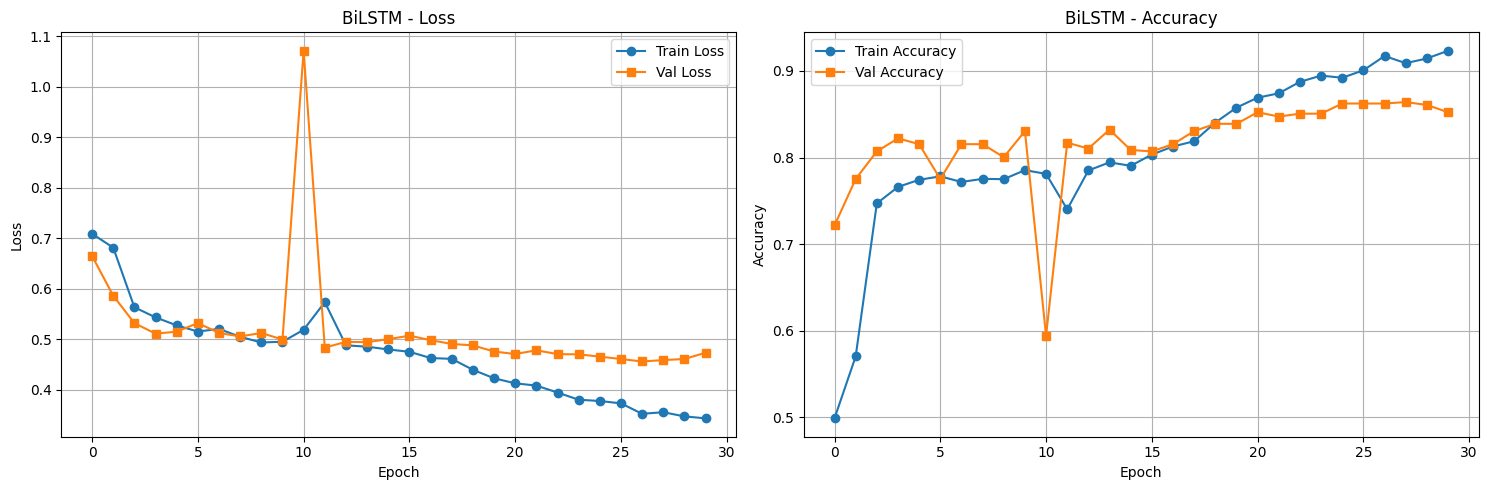

In [11]:
# Plot BiLSTM training history
plot_training_history(
    bilstm_train_losses, 
    bilstm_val_losses, 
    bilstm_train_accs, 
    bilstm_val_accs, 
    model_name="BiLSTM"
)

### BiLSTM Test Evaluation

Testing BiLSTM: 100%|██████████| 38/38 [00:00<00:00, 54.57it/s]



BiLSTM - TEST RESULTS
Accuracy:  0.8710
Precision: 0.8274
Recall:    0.9360
F1-Score:  0.8784
ROC-AUC:   0.9267
PR-AUC:    0.9143


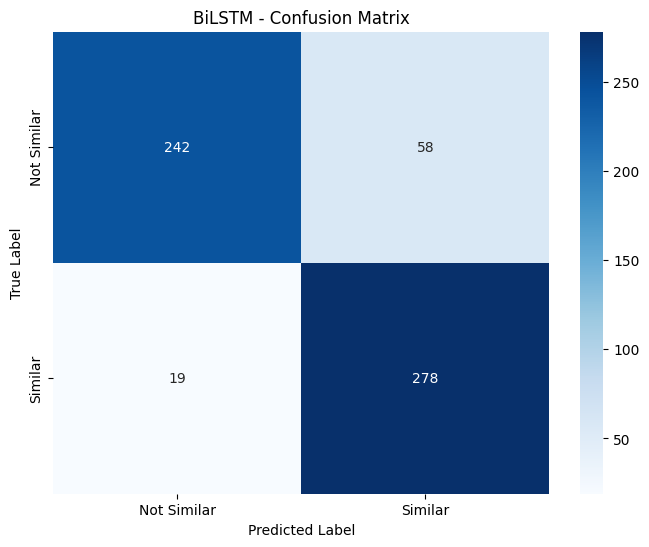

In [12]:
# Evaluate BiLSTM on test set
bilstm_results = evaluate_model(bilstm_model, test_loader, device, model_name="BiLSTM")

### BiLSTM ROC-AUC and PR-AUC Curves

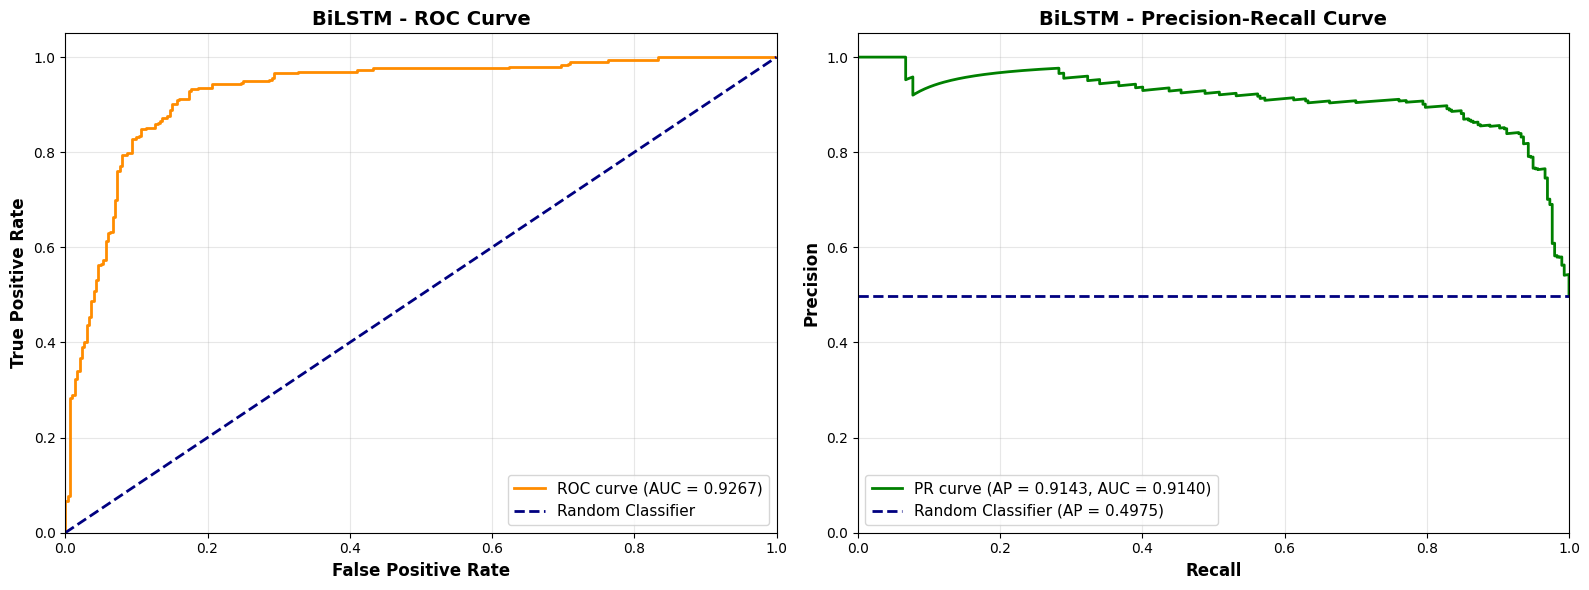


BiLSTM - Curve Analysis:
ROC-AUC Score: 0.9267
  - Measures overall discriminative ability
  - 1.0 = Perfect classifier, 0.5 = Random classifier

PR-AUC (Average Precision): 0.9143
  - Measures precision-recall trade-off
  - Better for imbalanced datasets
  - Random baseline: 0.4975



In [13]:
# Plot ROC and PR curves for BiLSTM
def plot_roc_pr_curves(results, model_name="Model"):
    """
    Plot ROC curve and Precision-Recall curve
    """
    labels = results['labels']
    probs = results['probabilities']
    
    # Calculate ROC curve
    fpr, tpr, roc_thresholds = roc_curve(labels, probs)
    roc_auc = auc(fpr, tpr)
    
    # Calculate PR curve
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(labels, probs)
    pr_auc = auc(recall_curve, precision_curve)
    avg_precision = average_precision_score(labels, probs)
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # ROC Curve
    ax1.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Random Classifier')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    ax1.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    ax1.set_title(f'{model_name} - ROC Curve', fontsize=14, fontweight='bold')
    ax1.legend(loc="lower right", fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Precision-Recall Curve
    ax2.plot(recall_curve, precision_curve, color='green', lw=2,
             label=f'PR curve (AP = {avg_precision:.4f}, AUC = {pr_auc:.4f})')
    
    # Baseline (random classifier) - proportion of positive class
    baseline = np.sum(labels) / len(labels)
    ax2.plot([0, 1], [baseline, baseline], color='navy', lw=2, 
             linestyle='--', label=f'Random Classifier (AP = {baseline:.4f})')
    
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Precision', fontsize=12, fontweight='bold')
    ax2.set_title(f'{model_name} - Precision-Recall Curve', fontsize=14, fontweight='bold')
    ax2.legend(loc="lower left", fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{model_name} - Curve Analysis:")
    print(f"{'='*50}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print(f"  - Measures overall discriminative ability")
    print(f"  - 1.0 = Perfect classifier, 0.5 = Random classifier")
    print(f"\nPR-AUC (Average Precision): {avg_precision:.4f}")
    print(f"  - Measures precision-recall trade-off")
    print(f"  - Better for imbalanced datasets")
    print(f"  - Random baseline: {baseline:.4f}")
    print(f"{'='*50}\n")

# Plot curves for BiLSTM
plot_roc_pr_curves(bilstm_results, model_name="BiLSTM")

## 7. Train Siamese CNN Model

Training the Siamese CNN baseline model from scratch with:
- Adam optimizer
- Binary Cross-Entropy loss
- Learning rate scheduling
- Early stopping

### Training Configuration and execution

In [14]:
# Siamese CNN optimizer and scheduler
optimizer_cnn = optim.Adam(siamese_cnn_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler_cnn = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_cnn, mode='min', factor=0.5, patience=3, verbose=True
)

cnn_train_losses, cnn_val_losses, cnn_train_accs, cnn_val_accs, cnn_best_state = train_model(
    model=siamese_cnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer_cnn,
    scheduler=scheduler_cnn,
    num_epochs=num_epochs,
    patience=patience,
    device=device,
    model_name="Siamese CNN"
)

TRAINING Siamese CNN

Epoch 1/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 376.48it/s]



Train Loss: 0.5483 | Train Acc: 0.7376
Val Loss: 0.5367 | Val Acc: 0.7718
Learning Rate: 0.001000
✓ New best model!

Epoch 2/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 395.34it/s]



Train Loss: 0.4345 | Train Acc: 0.8433
Val Loss: 0.4158 | Val Acc: 0.8540
Learning Rate: 0.001000
✓ New best model!

Epoch 3/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 389.33it/s]



Train Loss: 0.3564 | Train Acc: 0.9022
Val Loss: 0.3724 | Val Acc: 0.8977
Learning Rate: 0.001000
✓ New best model!

Epoch 4/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 389.95it/s]



Train Loss: 0.3233 | Train Acc: 0.9331
Val Loss: 0.4018 | Val Acc: 0.8742
Learning Rate: 0.001000
EarlyStopping counter: 1/10

Epoch 5/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 375.77it/s]



Train Loss: 0.2883 | Train Acc: 0.9551
Val Loss: 0.3360 | Val Acc: 0.9195
Learning Rate: 0.001000
✓ New best model!

Epoch 6/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 400.08it/s]



Train Loss: 0.2782 | Train Acc: 0.9572
Val Loss: 0.3348 | Val Acc: 0.9178
Learning Rate: 0.001000
✓ New best model!

Epoch 7/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 376.78it/s]



Train Loss: 0.2782 | Train Acc: 0.9572
Val Loss: 0.3192 | Val Acc: 0.9362
Learning Rate: 0.001000
✓ New best model!

Epoch 8/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 389.18it/s]



Train Loss: 0.2632 | Train Acc: 0.9659
Val Loss: 0.3862 | Val Acc: 0.8909
Learning Rate: 0.001000
EarlyStopping counter: 1/10

Epoch 9/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 391.97it/s]



Train Loss: 0.2611 | Train Acc: 0.9687
Val Loss: 0.3140 | Val Acc: 0.9379
Learning Rate: 0.001000
✓ New best model!

Epoch 10/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 386.69it/s]



Train Loss: 0.2473 | Train Acc: 0.9777
Val Loss: 0.3437 | Val Acc: 0.9128
Learning Rate: 0.001000
EarlyStopping counter: 1/10

Epoch 11/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 398.77it/s]



Train Loss: 0.2512 | Train Acc: 0.9759
Val Loss: 0.4641 | Val Acc: 0.8356
Learning Rate: 0.001000
EarlyStopping counter: 2/10

Epoch 12/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 360.17it/s]



Train Loss: 0.2453 | Train Acc: 0.9766
Val Loss: 0.3128 | Val Acc: 0.9396
Learning Rate: 0.001000
✓ New best model!

Epoch 13/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 361.02it/s]



Train Loss: 0.2368 | Train Acc: 0.9817
Val Loss: 0.3289 | Val Acc: 0.9161
Learning Rate: 0.001000
EarlyStopping counter: 1/10

Epoch 14/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 374.53it/s]



Train Loss: 0.2365 | Train Acc: 0.9845
Val Loss: 0.3059 | Val Acc: 0.9396
Learning Rate: 0.001000
✓ New best model!

Epoch 15/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 354.45it/s]



Train Loss: 0.2360 | Train Acc: 0.9853
Val Loss: 0.3553 | Val Acc: 0.8960
Learning Rate: 0.001000
EarlyStopping counter: 1/10

Epoch 16/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 392.77it/s]



Train Loss: 0.2440 | Train Acc: 0.9774
Val Loss: 0.2895 | Val Acc: 0.9497
Learning Rate: 0.001000
✓ New best model!

Epoch 17/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 371.28it/s]



Train Loss: 0.2271 | Train Acc: 0.9889
Val Loss: 0.3135 | Val Acc: 0.9245
Learning Rate: 0.001000
EarlyStopping counter: 1/10

Epoch 18/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 389.04it/s]



Train Loss: 0.2395 | Train Acc: 0.9831
Val Loss: 0.3396 | Val Acc: 0.9228
Learning Rate: 0.001000
EarlyStopping counter: 2/10

Epoch 19/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 391.05it/s]



Train Loss: 0.2415 | Train Acc: 0.9813
Val Loss: 0.2811 | Val Acc: 0.9513
Learning Rate: 0.001000
✓ New best model!

Epoch 20/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 369.69it/s]



Train Loss: 0.2384 | Train Acc: 0.9813
Val Loss: 0.3750 | Val Acc: 0.8876
Learning Rate: 0.001000
EarlyStopping counter: 1/10

Epoch 21/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 385.31it/s]



Train Loss: 0.2358 | Train Acc: 0.9860
Val Loss: 0.3017 | Val Acc: 0.9396
Learning Rate: 0.001000
EarlyStopping counter: 2/10

Epoch 22/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 376.96it/s]



Train Loss: 0.2409 | Train Acc: 0.9799
Val Loss: 0.3267 | Val Acc: 0.9329
Learning Rate: 0.001000
EarlyStopping counter: 3/10

Epoch 23/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 399.55it/s]



Train Loss: 0.2304 | Train Acc: 0.9871
Val Loss: 0.2757 | Val Acc: 0.9581
Learning Rate: 0.001000
✓ New best model!

Epoch 24/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 381.41it/s]



Train Loss: 0.2218 | Train Acc: 0.9935
Val Loss: 0.2818 | Val Acc: 0.9497
Learning Rate: 0.001000
EarlyStopping counter: 1/10

Epoch 25/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 386.52it/s]



Train Loss: 0.2298 | Train Acc: 0.9860
Val Loss: 0.3291 | Val Acc: 0.9195
Learning Rate: 0.001000
EarlyStopping counter: 2/10

Epoch 26/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 391.79it/s]



Train Loss: 0.2353 | Train Acc: 0.9820
Val Loss: 0.2776 | Val Acc: 0.9547
Learning Rate: 0.001000
EarlyStopping counter: 3/10

Epoch 27/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 386.56it/s]



Train Loss: 0.2256 | Train Acc: 0.9914
Val Loss: 0.2910 | Val Acc: 0.9497
Learning Rate: 0.000500
EarlyStopping counter: 4/10

Epoch 28/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 322.41it/s]



Train Loss: 0.2298 | Train Acc: 0.9878
Val Loss: 0.3060 | Val Acc: 0.9312
Learning Rate: 0.000500
EarlyStopping counter: 5/10

Epoch 29/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 392.46it/s]



Train Loss: 0.2180 | Train Acc: 0.9953
Val Loss: 0.3213 | Val Acc: 0.9295
Learning Rate: 0.000500
EarlyStopping counter: 6/10

Epoch 30/30
----------------------------------------------------------------------


Validating: 100%|██████████| 38/38 [00:00<00:00, 380.63it/s]


Train Loss: 0.2178 | Train Acc: 0.9953
Val Loss: 0.3007 | Val Acc: 0.9463
Learning Rate: 0.000500
EarlyStopping counter: 7/10
TRAINING Siamese CNN COMPLETED!


### Siamese CNN Training History

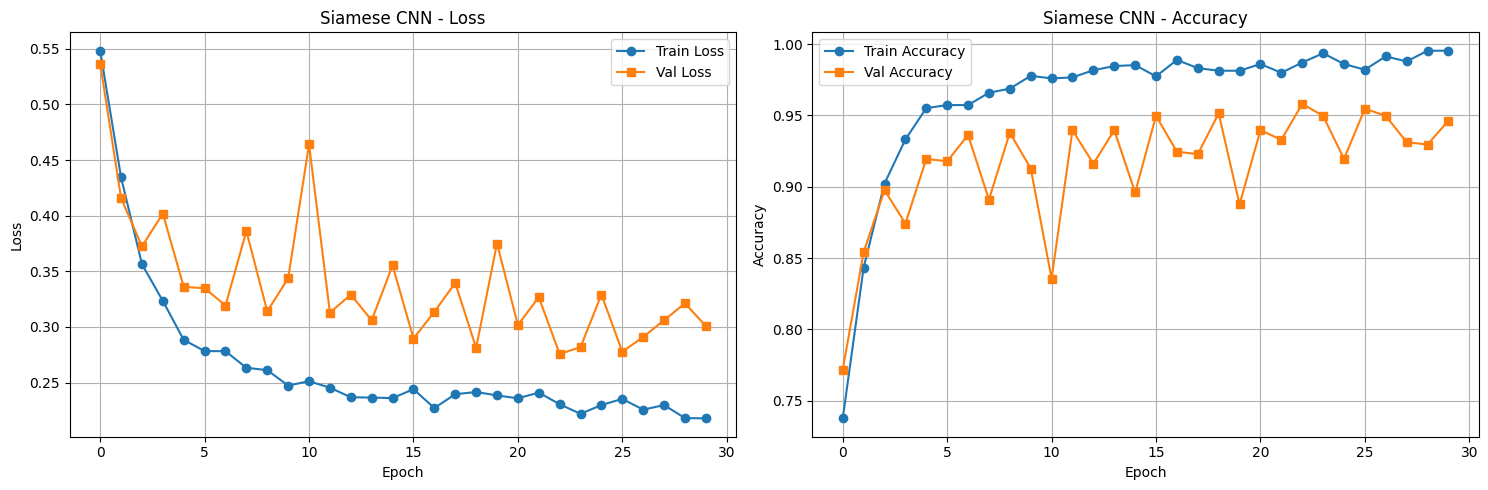

In [15]:
# Plot Siamese CNN training history
plot_training_history(
    cnn_train_losses, 
    cnn_val_losses, 
    cnn_train_accs, 
    cnn_val_accs, 
    model_name="Siamese CNN"
)

### Siamese CNN Test Evaluation

Testing Siamese CNN: 100%|██████████| 38/38 [00:00<00:00, 284.13it/s]



Siamese CNN - TEST RESULTS
Accuracy:  0.9497
Precision: 0.9238
Recall:    0.9798
F1-Score:  0.9510
ROC-AUC:   0.9824
PR-AUC:    0.9790


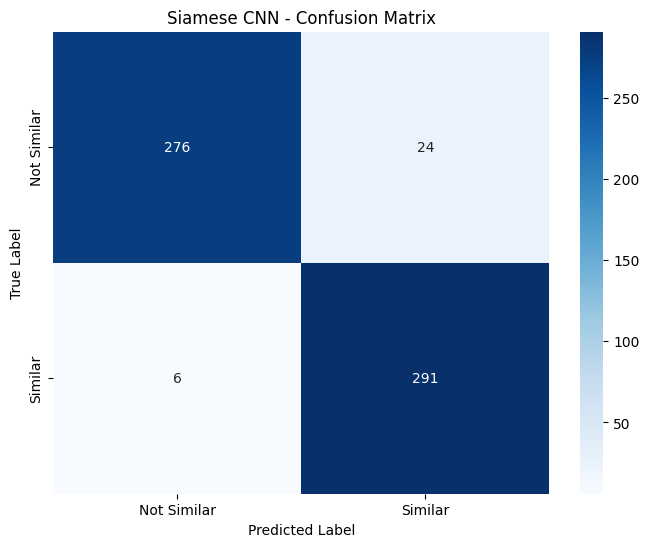

In [16]:
# Evaluate Siamese CNN on test set
cnn_results = evaluate_model(siamese_cnn_model, test_loader, device, model_name="Siamese CNN")

### Siamese CNN ROC-AUC and PR-AUC Curves

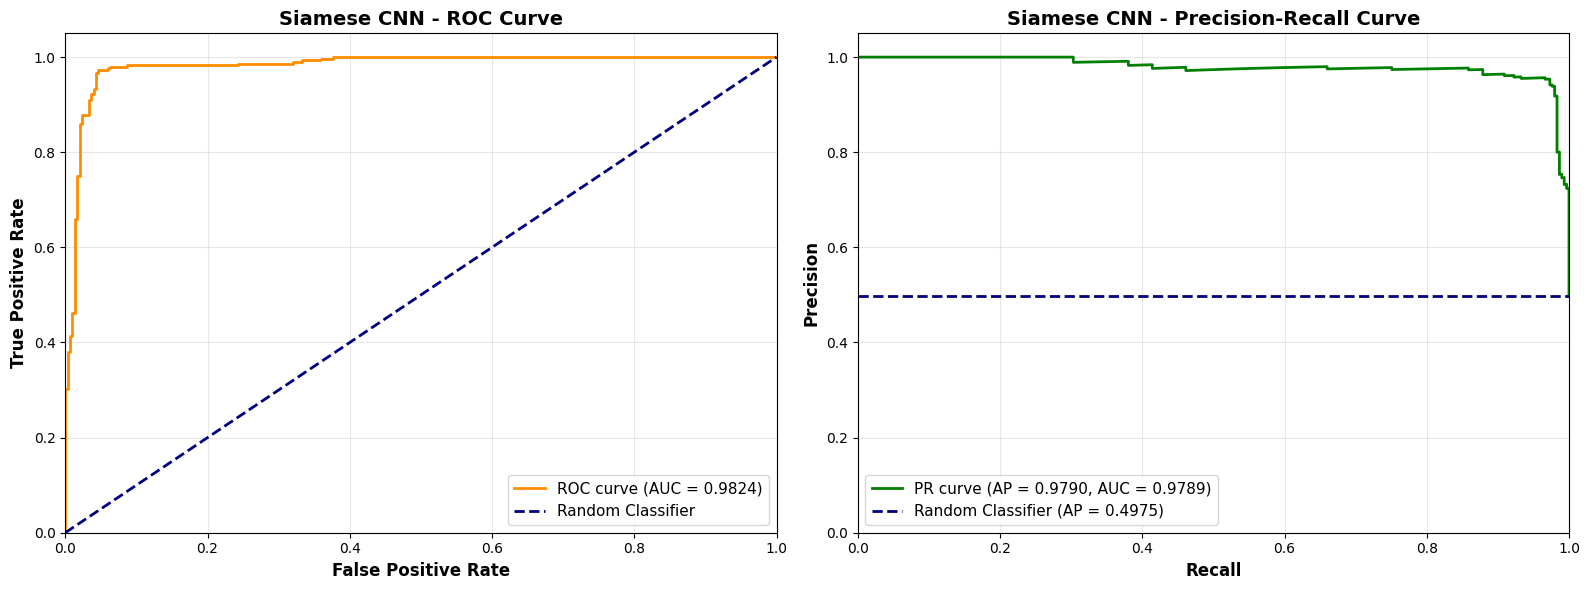


Siamese CNN - Curve Analysis:
ROC-AUC Score: 0.9824
  - Measures overall discriminative ability
  - 1.0 = Perfect classifier, 0.5 = Random classifier

PR-AUC (Average Precision): 0.9790
  - Measures precision-recall trade-off
  - Better for imbalanced datasets
  - Random baseline: 0.4975



In [17]:
# Plot curves for Siamese CNN
plot_roc_pr_curves(cnn_results, model_name="Siamese CNN")

## 8. Model Comparison and Analysis


MODEL COMPARISON - TEST SET PERFORMANCE
      Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC   PR-AUC
     BiLSTM  0.871022   0.827381 0.936027  0.878357 0.926734 0.914275
Siamese CNN  0.949749   0.923810 0.979798  0.950980 0.982368 0.978951


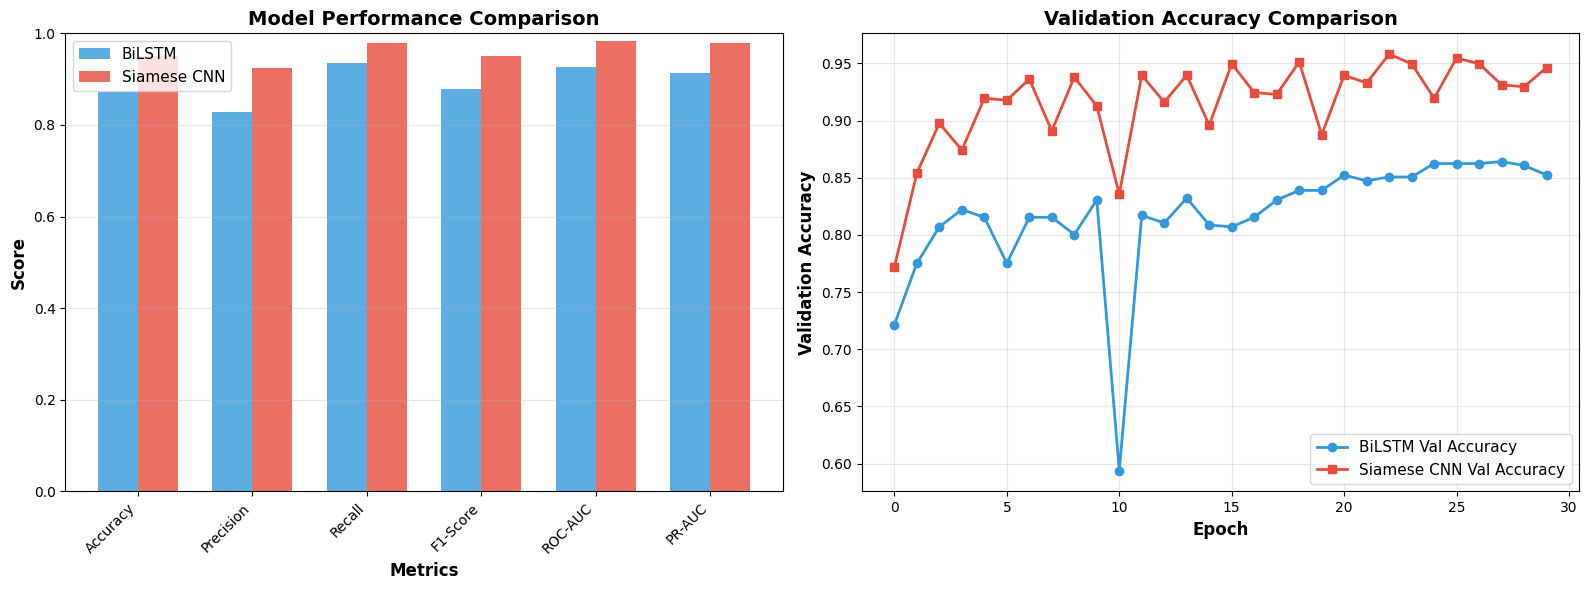

In [18]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['BiLSTM', 'Siamese CNN'],
    'Accuracy': [bilstm_results['accuracy'], cnn_results['accuracy']],
    'Precision': [bilstm_results['precision'], cnn_results['precision']],
    'Recall': [bilstm_results['recall'], cnn_results['recall']],
    'F1-Score': [bilstm_results['f1'], cnn_results['f1']],
    'ROC-AUC': [bilstm_results['roc_auc'], cnn_results['roc_auc']],
    'PR-AUC': [bilstm_results['pr_auc'], cnn_results['pr_auc']]
})

print("\n" + "="*70)
print("MODEL COMPARISON - TEST SET PERFORMANCE")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Visualization of comparison

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot - Performance metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC']
x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, comparison_df.iloc[0, 1:], width, 
           label='BiLSTM', color='#3498db', alpha=0.8)
axes[0].bar(x + width/2, comparison_df.iloc[1, 1:], width, 
           label='Siamese CNN', color='#e74c3c', alpha=0.8)
axes[0].set_xlabel('Metrics', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, rotation=45, ha='right')
axes[0].legend(fontsize=11)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1.0])

# Line plot - Validation accuracy comparison
axes[1].plot(bilstm_val_accs, label='BiLSTM Val Accuracy', 
            marker='o', linewidth=2, color='#3498db')
axes[1].plot(cnn_val_accs, label='Siamese CNN Val Accuracy', 
            marker='s', linewidth=2, color='#e74c3c')
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Validation Accuracy', fontsize=12, fontweight='bold')
axes[1].set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Combined ROC and PR Curves Comparison

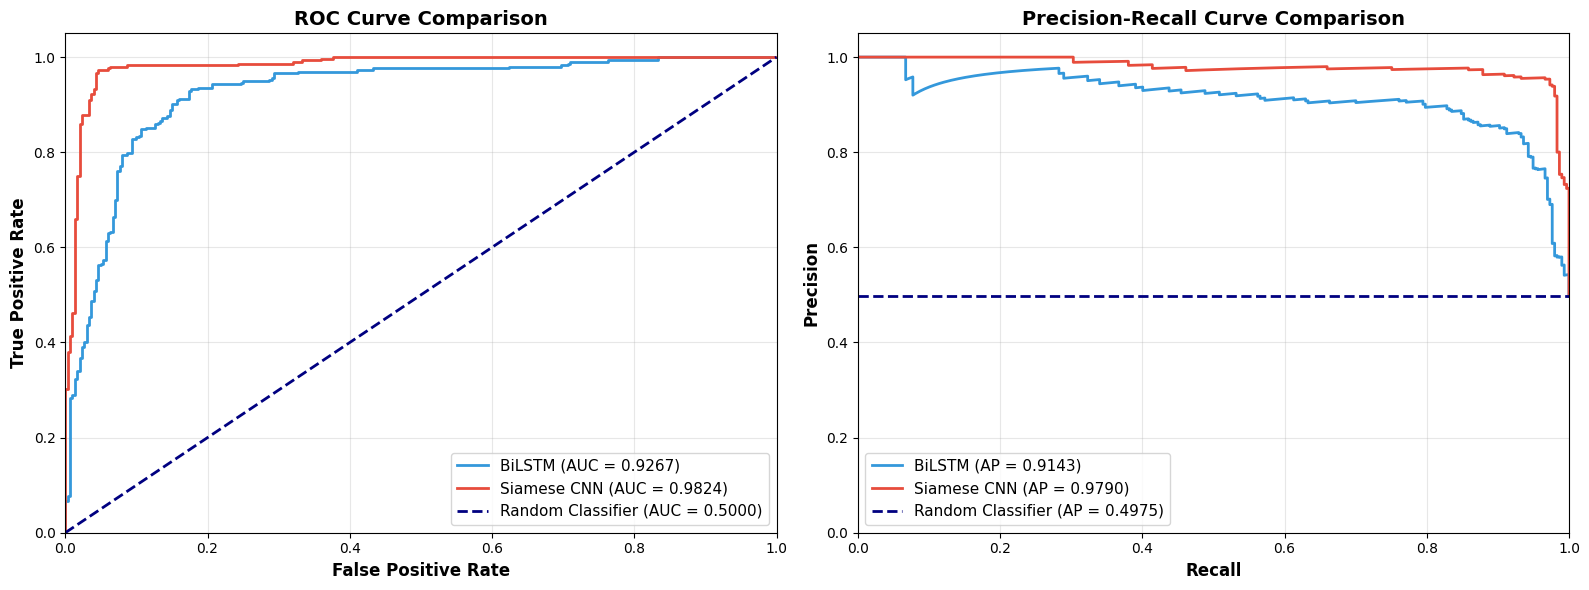


COMBINED CURVE ANALYSIS:

ROC-AUC Scores:
  BiLSTM:       0.9267
  Siamese CNN:  0.9824
  Difference:   0.0556

PR-AUC (Average Precision) Scores:
  BiLSTM:       0.9143
  Siamese CNN:  0.9790
  Difference:   0.0647
  Baseline:     0.4975

INTERPRETATION:
ROC-AUC:
  - Measures the model's ability to distinguish between classes
  - Higher is better (max = 1.0, random = 0.5)
  - Good for balanced datasets

PR-AUC (Average Precision):
  - Focuses on precision-recall trade-off
  - More informative for imbalanced datasets
  - Higher is better, compare against random baseline
  - Emphasizes performance on positive class


In [19]:
# Compare ROC and PR curves for both models
def plot_combined_roc_pr_curves(bilstm_results, cnn_results):
    """
    Plot ROC and PR curves for both models on the same figure for comparison
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # ROC Curves
    for results, model_name, color in [
        (bilstm_results, 'BiLSTM', '#3498db'),
        (cnn_results, 'Siamese CNN', '#e74c3c')
    ]:
        labels = results['labels']
        probs = results['probabilities']
        
        fpr, tpr, _ = roc_curve(labels, probs)
        roc_auc = auc(fpr, tpr)
        
        ax1.plot(fpr, tpr, color=color, lw=2, 
                label=f'{model_name} (AUC = {roc_auc:.4f})')
    
    # Random classifier baseline
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
            label='Random Classifier (AUC = 0.5000)')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    ax1.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    ax1.set_title('ROC Curve Comparison', fontsize=14, fontweight='bold')
    ax1.legend(loc="lower right", fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Precision-Recall Curves
    baseline = np.sum(bilstm_results['labels']) / len(bilstm_results['labels'])
    
    for results, model_name, color in [
        (bilstm_results, 'BiLSTM', '#3498db'),
        (cnn_results, 'Siamese CNN', '#e74c3c')
    ]:
        labels = results['labels']
        probs = results['probabilities']
        
        precision_curve, recall_curve, _ = precision_recall_curve(labels, probs)
        avg_precision = average_precision_score(labels, probs)
        
        ax2.plot(recall_curve, precision_curve, color=color, lw=2,
                label=f'{model_name} (AP = {avg_precision:.4f})')
    
    # Random classifier baseline
    ax2.plot([0, 1], [baseline, baseline], color='navy', lw=2, 
            linestyle='--', label=f'Random Classifier (AP = {baseline:.4f})')
    
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Precision', fontsize=12, fontweight='bold')
    ax2.set_title('Precision-Recall Curve Comparison', fontsize=14, fontweight='bold')
    ax2.legend(loc="lower left", fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nCOMBINED CURVE ANALYSIS:")
    print("="*70)
    print(f"\nROC-AUC Scores:")
    print(f"  BiLSTM:       {bilstm_results['roc_auc']:.4f}")
    print(f"  Siamese CNN:  {cnn_results['roc_auc']:.4f}")
    print(f"  Difference:   {abs(bilstm_results['roc_auc'] - cnn_results['roc_auc']):.4f}")
    
    print(f"\nPR-AUC (Average Precision) Scores:")
    print(f"  BiLSTM:       {bilstm_results['pr_auc']:.4f}")
    print(f"  Siamese CNN:  {cnn_results['pr_auc']:.4f}")
    print(f"  Difference:   {abs(bilstm_results['pr_auc'] - cnn_results['pr_auc']):.4f}")
    print(f"  Baseline:     {baseline:.4f}")
    
    print("\n" + "="*70)
    print("INTERPRETATION:")
    print("="*70)
    print("ROC-AUC:")
    print("  - Measures the model's ability to distinguish between classes")
    print("  - Higher is better (max = 1.0, random = 0.5)")
    print("  - Good for balanced datasets")
    print("\nPR-AUC (Average Precision):")
    print("  - Focuses on precision-recall trade-off")
    print("  - More informative for imbalanced datasets")
    print("  - Higher is better, compare against random baseline")
    print("  - Emphasizes performance on positive class")
    print("="*70)

# Plot combined comparison
plot_combined_roc_pr_curves(bilstm_results, cnn_results)

## 9. Save Trained Models

In [20]:
import os

model_dir = 'saved_models'
os.makedirs(model_dir, exist_ok=True)

# Save BiLSTM model
bilstm_checkpoint = {
    'model_state_dict': bilstm_best_state,
    'optimizer_state_dict': optimizer_bilstm.state_dict(),
    'word2idx': word2idx,
    'idx2word': idx2word,
    'vocab_size': vocab_size,
    'max_length': max_length,
    'results': bilstm_results,
    'train_losses': bilstm_train_losses,
    'val_losses': bilstm_val_losses,
    'train_accs': bilstm_train_accs,
    'val_accs': bilstm_val_accs
}
torch.save(bilstm_checkpoint, os.path.join(model_dir, 'bilstm_legal_clause.pth'))
print("✓ BiLSTM model saved to:", os.path.join(model_dir, 'bilstm_legal_clause.pth'))

# Save Siamese CNN model
cnn_checkpoint = {
    'model_state_dict': cnn_best_state,
    'optimizer_state_dict': optimizer_cnn.state_dict(),
    'word2idx': word2idx,
    'idx2word': idx2word,
    'vocab_size': vocab_size,
    'max_length': max_length,
    'results': cnn_results,
    'train_losses': cnn_train_losses,
    'val_losses': cnn_val_losses,
    'train_accs': cnn_train_accs,
    'val_accs': cnn_val_accs
}
torch.save(cnn_checkpoint, os.path.join(model_dir, 'siamese_cnn_legal_clause.pth'))
print("✓ Siamese CNN model saved to:", os.path.join(model_dir, 'siamese_cnn_legal_clause.pth'))

print(f"\n{'='*70}")
print(f"All models saved successfully in '{model_dir}/' directory")
print(f"{'='*70}")

✓ BiLSTM model saved to: saved_models/bilstm_legal_clause.pth
✓ Siamese CNN model saved to: saved_models/siamese_cnn_legal_clause.pth

All models saved successfully in 'saved_models/' directory


## 10. Inference Example - Test on New Clause Pairs

In [21]:
# Predict similarity between two clauses
def predict_similarity(model, text1, text2, word2idx, max_length, device):
    model.eval()
    
    # Encode texts
    encoded1 = encode_text(text1, word2idx, max_length)
    encoded2 = encode_text(text2, word2idx, max_length)
    
    # Convert to tensors
    text1_tensor = torch.LongTensor(encoded1).unsqueeze(0).to(device)
    text2_tensor = torch.LongTensor(encoded2).unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        similarity_score = model(text1_tensor, text2_tensor).item()
    
    return similarity_score


print("INFERENCE EXAMPLES - Legal Clause Similarity")

# Test with example clause pairs
test_indices = [0, 5, 10, 15, 20]

for idx in test_indices[:min(len(test_indices), len(text1_test))]:
    clause1 = text1_test[idx]
    clause2 = text2_test[idx]
    true_label = y_test[idx]
    
    # Predict with both models
    bilstm_score = predict_similarity(bilstm_model, clause1, clause2, word2idx, max_length, device)
    cnn_score = predict_similarity(siamese_cnn_model, clause1, clause2, word2idx, max_length, device)
    
    print(f"\n{'='*70}")
    print(f"Example {idx + 1}")
    print(f"{'='*70}")
    print(f"Clause 1: {clause1[:150]}...")
    print(f"\nClause 2: {clause2[:150]}...")
    print(f"\nTrue Label: {'✓ SIMILAR' if true_label == 1 else '✗ DISSIMILAR'}")
    print(f"\nPredictions:")
    print(f"  BiLSTM:       {bilstm_score:.4f} ({'✓ SIMILAR' if bilstm_score > 0.5 else '✗ DISSIMILAR'})")
    print(f"  Siamese CNN:  {cnn_score:.4f} ({'✓ SIMILAR' if cnn_score > 0.5 else '✗ DISSIMILAR'})")
    
    # Check if predictions match
    bilstm_correct = (bilstm_score > 0.5) == (true_label == 1)
    cnn_correct = (cnn_score > 0.5) == (true_label == 1)
    
    print(f"\nCorrect Predictions:")
    print(f"  BiLSTM:       {'✓' if bilstm_correct else '✗'}")
    print(f"  Siamese CNN:  {'✓' if cnn_correct else '✗'}")
    print(f"{'='*70}")

print("\n Inference completed successfully!")

INFERENCE EXAMPLES - Legal Clause Similarity

Example 1
Clause 1: REPRESENTATIONS AND WARRANTIES OF SELLER. Seller represents and warrants to Buyer as follows:...

Clause 2: REPRESENTATIONS AND WARRANTIES OF SELLER. Seller represents and warrants to Purchaser as follows:...

True Label: ✓ SIMILAR

Predictions:
  BiLSTM:       0.8152 (✓ SIMILAR)
  Siamese CNN:  0.9485 (✓ SIMILAR)

Correct Predictions:
  BiLSTM:       ✓
  Siamese CNN:  ✓

Example 6
Clause 1: Bank Accounts. The Custodian shall identify on its books as belonging to the applicable Fund cash (including cash denominated in foreign currencies) d...

Clause 2: Bank Accounts. The Custodian shall open and maintain a separate bank account or accounts in the United States in the name of each Portfolio of each Fu...

True Label: ✓ SIMILAR

Predictions:
  BiLSTM:       0.9340 (✓ SIMILAR)
  Siamese CNN:  0.9645 (✓ SIMILAR)

Correct Predictions:
  BiLSTM:       ✓
  Siamese CNN:  ✓

Example 11
Clause 1: Restrictions. The Owner Trustee s


MODEL COMPARISON SUMMARY
      Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC   PR-AUC
     BiLSTM  0.871022   0.827381 0.936027  0.878357 0.926734 0.914275
Siamese CNN  0.949749   0.923810 0.979798  0.950980 0.982368 0.978951


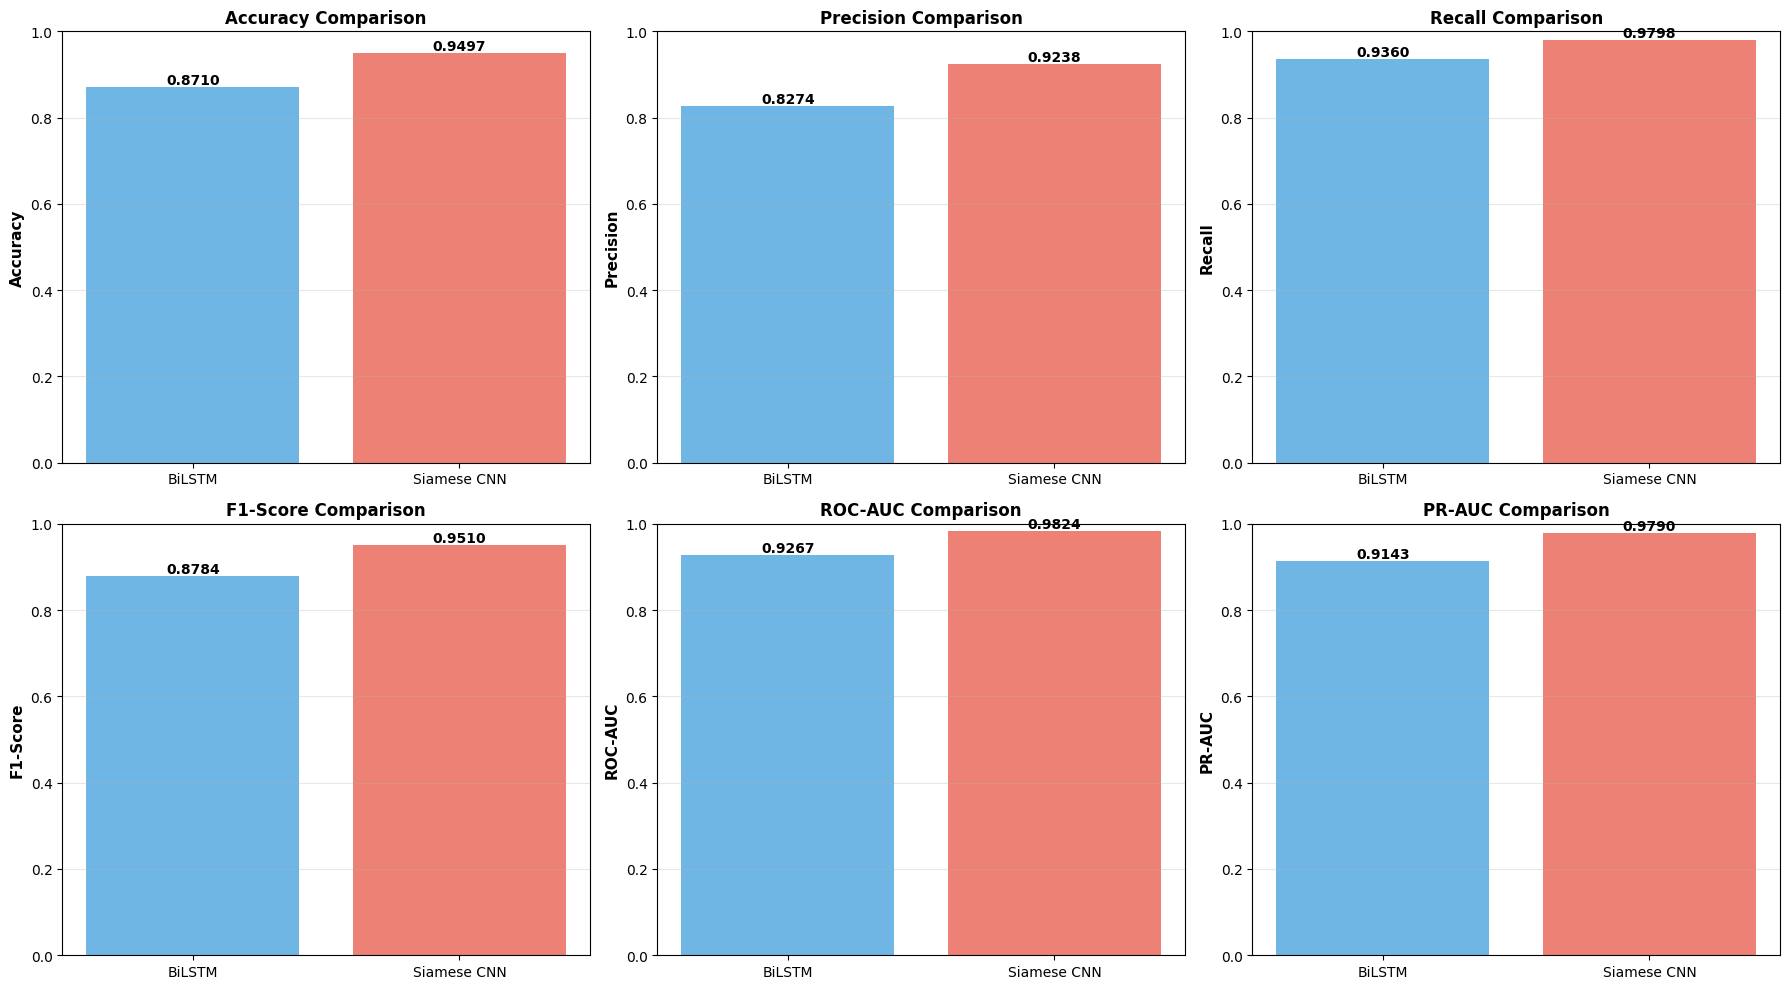


KEY FINDINGS:
Best Model (ROC-AUC): Siamese CNN

ACCURACY:
  BiLSTM: 0.8710 | Siamese CNN: 0.9497
  Better: Siamese CNN (Δ = 0.0787)

PRECISION:
  BiLSTM: 0.8274 | Siamese CNN: 0.9238
  Better: Siamese CNN (Δ = 0.0964)

RECALL:
  BiLSTM: 0.9360 | Siamese CNN: 0.9798
  Better: Siamese CNN (Δ = 0.0438)

F1:
  BiLSTM: 0.8784 | Siamese CNN: 0.9510
  Better: Siamese CNN (Δ = 0.0726)

ROC-AUC:
  BiLSTM: 0.9267 | Siamese CNN: 0.9824
  Better: Siamese CNN (Δ = 0.0556)

PR-AUC:
  BiLSTM: 0.9143 | Siamese CNN: 0.9790
  Better: Siamese CNN (Δ = 0.0647)


In [22]:
# Compare both models
comparison_df = pd.DataFrame({
    'Model': ['BiLSTM', 'Siamese CNN'],
    'Accuracy': [bilstm_results['accuracy'], cnn_results['accuracy']],
    'Precision': [bilstm_results['precision'], cnn_results['precision']],
    'Recall': [bilstm_results['recall'], cnn_results['recall']],
    'F1-Score': [bilstm_results['f1'], cnn_results['f1']],
    'ROC-AUC': [bilstm_results['roc_auc'], cnn_results['roc_auc']],
    'PR-AUC': [bilstm_results['pr_auc'], cnn_results['pr_auc']]
})

print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Visualize comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    values = comparison_df[metric].values
    bars = ax.bar(['BiLSTM', 'Siamese CNN'], values, color=['#3498db', '#e74c3c'], alpha=0.7)
    ax.set_ylabel(metric, fontsize=11, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Summary statistics
print("\nKEY FINDINGS:")
print("="*70)
best_model = 'BiLSTM' if bilstm_results['roc_auc'] > cnn_results['roc_auc'] else 'Siamese CNN'
print(f"Best Model (ROC-AUC): {best_model}")

for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc']:
    bilstm_val = bilstm_results[metric]
    cnn_val = cnn_results[metric]
    diff = abs(bilstm_val - cnn_val)
    better = 'BiLSTM' if bilstm_val > cnn_val else 'Siamese CNN'
    print(f"\n{metric.upper().replace('_', '-')}:")
    print(f"  BiLSTM: {bilstm_val:.4f} | Siamese CNN: {cnn_val:.4f}")
    print(f"  Better: {better} (Δ = {diff:.4f})")
print("="*70)